### DSC672 Group 10 Final Project
Classification, Clustering, and Time Series Analysis of London Smart Meter Data

by: Jennifer Franks and Josh Hall

In [7]:
import pandas as pd
import numpy as np
import glob
from utils import read_data, print_model_acc, voting_system

The data I acquired from https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households comes in 168 .csv files of 1 million rows each. So, the first thing I must do is stitch all the files together to create a single dataframe for further processing. 

# 1. Data Cleaning

In [8]:
# path = r'C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data'
path = '../data/'
df = read_data(path) # Get the data.

In [9]:
df # Here is the inital dataframe.

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn,Acorn_grouped
0,MAC000002,Std,10/12/2012 0:30,NaN,ACORN-A,Affluent
1,MAC000002,Std,10/12/2012 1:00,NaN,ACORN-A,Affluent
2,MAC000002,Std,10/12/2012 1:30,NaN,ACORN-A,Affluent
3,MAC000002,Std,10/12/2012 2:00,NaN,ACORN-A,Affluent
4,MAC000002,Std,10/12/2012 2:30,NaN,ACORN-A,Affluent
...,...,...,...,...,...,...
167932469,MAC004221,Std,2013-08-06 04:30:00.0000000,0.017,ACORN-E,Affluent
167932470,MAC004221,Std,2013-08-06 05:00:00.0000000,0.017,ACORN-E,Affluent
167932471,MAC004221,Std,2013-08-06 05:30:00.0000000,0.017,ACORN-E,Affluent
167932472,MAC004221,Std,2013-08-06 06:00:00.0000000,0.017,ACORN-E,Affluent


Next, I will be cleaning the data to make it easier to work with and getting it into the right format.

In [10]:
df.rename(columns={'KWH/hh (per half hour) ' : 'KWH/hh'}, inplace=True) # Rename column to make easier to read.

Here we fill NaN's with floating point zero's, replace Null's with zero's, and covert the KWH/hh column from string to float.

In [11]:
df.fillna(0.0, inplace=True)
df['KWH/hh'].replace('Null', 0, inplace=True) 
df['KWH/hh'] = df['KWH/hh'].astype(float) 

Convert DateTime column to datetime datetype.

In [12]:
df['DateTime'] = pd.to_datetime(df['DateTime']) # convert to datetime datetype

Drop the rows that have "ACORN-U" or  "ACORN-" values as there ACORN_grouped classification because thoes values don't have a meaning.

In [13]:
# drop the rows that have one of the bewlow values in 'Acorn_grouped'
df = df.drop(df[(df.Acorn_grouped == "ACORN-U") | (df.Acorn_grouped == "ACORN-")].index)

Here is the initial clean dataframe.

In [14]:
df

,LCLid,stdorToU,DateTime,KWH/hh,Acorn,Acorn_grouped
0,MAC000002,Std,2012-10-12 00:30:00,0.000,ACORN-A,Affluent
1,MAC000002,Std,2012-10-12 01:00:00,0.000,ACORN-A,Affluent
2,MAC000002,Std,2012-10-12 01:30:00,0.000,ACORN-A,Affluent
3,MAC000002,Std,2012-10-12 02:00:00,0.000,ACORN-A,Affluent
4,MAC000002,Std,2012-10-12 02:30:00,0.000,ACORN-A,Affluent
...,...,...,...,...,...,...
167932469,MAC004221,Std,2013-08-06 04:30:00,0.017,ACORN-E,Affluent
167932470,MAC004221,Std,2013-08-06 05:00:00,0.017,ACORN-E,Affluent
167932471,MAC004221,Std,2013-08-06 05:30:00,0.017,ACORN-E,Affluent
167932472,MAC004221,Std,2013-08-06 06:00:00,0.017,ACORN-E,Affluent


Since I am working with a time series dataset, I need to figure out which time slice of the data I can use. Ideally, I am looking for 2 years’ worth of data to have a historical year to predict off of then use the next year for testing.

In [15]:
gb1 = df.groupby('LCLid') # group by ID to be able to look at the start and end dates so as to figure out where to slice.

In [16]:
min(gb1.first().DateTime) # earlist start

Timestamp('2011-11-23 09:00:00')

In [17]:
 max(gb1.first().DateTime) # latest start

Timestamp('2013-10-29 18:23:02')

In [18]:
min(gb1.last().DateTime) # earlist stop

Timestamp('2012-05-01 21:00:00')

In [19]:
 max(gb1.last().DateTime) # latest stop

Timestamp('2014-02-28 00:00:00')

At this point it seems that the data isn’t very consistent. For, example the last date that a time series starts is 29/10/2013 which overtakes the earliest date a time series stops at 1/5/2012. This means that all my series don’t start and stop at the same time. 

This presents problems because one, we wanted at least 2 years of data and and we cant have that if the series dont go back that far. Two, if we keep all the data we would have to pad the missing values with zeros which would be detrimental to the performance of the learning algorithms and give poor results when computing other statistics. 

I ended up finding an acceptable date on which to cut the series. Starting on 01/01/2013 and end 01/01/2014. This equals one year of data.

In [20]:
df2 = df.set_index(['DateTime'])
df2 = df2.loc['2013-01-01':'2014-01-01'] # 1 year of data.

In [21]:
df2

,LCLid,stdorToU,KWH/hh,Acorn,Acorn_grouped
DateTime,,,,,
2013-01-01 00:00:00,MAC000002,Std,0.219,ACORN-A,Affluent
2013-01-01 00:30:00,MAC000002,Std,0.241,ACORN-A,Affluent
2013-01-01 01:00:00,MAC000002,Std,0.191,ACORN-A,Affluent
2013-01-01 01:30:00,MAC000002,Std,0.235,ACORN-A,Affluent
2013-01-01 02:00:00,MAC000002,Std,0.182,ACORN-A,Affluent
...,...,...,...,...,...
2013-08-06 04:30:00,MAC004221,Std,0.017,ACORN-E,Affluent
2013-08-06 05:00:00,MAC004221,Std,0.017,ACORN-E,Affluent
2013-08-06 05:30:00,MAC004221,Std,0.017,ACORN-E,Affluent


Next, I made sure that each series had an actual years worth of values. I first group each 'LCLid' which is the primary key for each series by the count of how many rows they have. If the number of rows for each series doesnt equal 17,580 rows I exluded that id from my dataframe. 

The reason they must have 17,580 rows is because the data is read at half-hour intevals over the year. 48 rows a day times 366 for a years worth of data.

In [22]:
df2 = df2.reset_index() # Remove datetime from index.
gb2 = df2.groupby(['LCLid']).DateTime.count() # Group df by id and get count of the # of rows.
df3 = pd.DataFrame(gb2) # Put gb in df.
df3.rename(columns={'DateTime': '# of rows for each series'}, inplace=True)

In [23]:
df3

,# of rows for each series
LCLid,
MAC000002,17580
MAC000003,17578
MAC000004,17579
MAC000005,17579
MAC000006,17580
...,...
MAC005561,17575
MAC005562,17579
MAC005564,17571


In [24]:
lst_for_good_ids = [17580] # Series whos # of rows equals 17,580.
# Filter df for only series of len 17,580.
df4 = pd.DataFrame(df3.loc[df3['# of rows for each series'].isin(lst_for_good_ids)])

Here I filter the dataframe to only include LCLids that have 17,580 rows.

In [25]:
df6 = pd.DataFrame(df2.loc[df2['LCLid'].isin(df4.index.to_list())])
df6

,DateTime,LCLid,stdorToU,KWH/hh,Acorn,Acorn_grouped
0,2013-01-01 00:00:00,MAC000002,Std,0.219,ACORN-A,Affluent
1,2013-01-01 00:30:00,MAC000002,Std,0.241,ACORN-A,Affluent
2,2013-01-01 01:00:00,MAC000002,Std,0.191,ACORN-A,Affluent
3,2013-01-01 01:30:00,MAC000002,Std,0.235,ACORN-A,Affluent
4,2013-01-01 02:00:00,MAC000002,Std,0.182,ACORN-A,Affluent
...,...,...,...,...,...,...
92477104,2014-01-01 21:30:00,MAC004219,Std,0.266,ACORN-E,Affluent
92477105,2014-01-01 22:00:00,MAC004219,Std,0.260,ACORN-E,Affluent
92477106,2014-01-01 22:30:00,MAC004219,Std,0.301,ACORN-E,Affluent
92477107,2014-01-01 23:00:00,MAC004219,Std,0.223,ACORN-E,Affluent


Now, that I've achieved a years’ worth of data I want to add columns that will assist in answering our classification question and give us more insight into our data.

Here I will add the day of the week to differentiate analysis from weekday or weekend since power consumption is likely to change depending on the day of the week because these are residential meters.

Also, I add the hourly temperature. Since our data is half hourly I take the previous temperature and the next temperature and average them to fille the temperature for the missing half hour.


In [26]:
df6['Day'] = df6['DateTime'].dt.day_name() # Add the day of the week.

In [28]:
path2 = r'C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\london 2013 temp.csv'
df_temp = pd.read_csv(path2) # Load hourly temp data for London, UK in 2013.

In [29]:
df_temp
df_temp['DateTime'] = pd.to_datetime(df_temp['ob_time']) # convert to datetime datetype
df_temp.drop(['ob_time'], axis=1, inplace = True)

In [30]:
df7 = pd.merge(df6,df_temp ,on='DateTime',how='left')
df7['air_temperature'] = df7['air_temperature'].interpolate() # Fill in missing values for temp.
df7['air_temperature'] = df7['air_temperature'] * 1.8 + 32 # Convert to F degress.

In [31]:
df7

,DateTime,LCLid,stdorToU,KWH/hh,Acorn,Acorn_grouped,Day,air_temperature
0,2013-01-01 00:00:00,MAC000002,Std,0.219,ACORN-A,Affluent,Tuesday,48.02
1,2013-01-01 00:30:00,MAC000002,Std,0.241,ACORN-A,Affluent,Tuesday,47.84
2,2013-01-01 01:00:00,MAC000002,Std,0.191,ACORN-A,Affluent,Tuesday,47.66
3,2013-01-01 01:30:00,MAC000002,Std,0.235,ACORN-A,Affluent,Tuesday,47.39
4,2013-01-01 02:00:00,MAC000002,Std,0.182,ACORN-A,Affluent,Tuesday,47.12
...,...,...,...,...,...,...,...,...
19654435,2014-01-01 21:30:00,MAC004219,Std,0.266,ACORN-E,Affluent,Wednesday,42.80
19654436,2014-01-01 22:00:00,MAC004219,Std,0.260,ACORN-E,Affluent,Wednesday,42.80
19654437,2014-01-01 22:30:00,MAC004219,Std,0.301,ACORN-E,Affluent,Wednesday,42.80
19654438,2014-01-01 23:00:00,MAC004219,Std,0.223,ACORN-E,Affluent,Wednesday,42.80


Finally, I add the month to our data.

In [32]:
df7['Month'] = df7['DateTime'].dt.strftime('%B')

In [33]:
df7

,DateTime,LCLid,stdorToU,KWH/hh,Acorn,Acorn_grouped,Day,air_temperature,Month
0,2013-01-01 00:00:00,MAC000002,Std,0.219,ACORN-A,Affluent,Tuesday,48.02,January
1,2013-01-01 00:30:00,MAC000002,Std,0.241,ACORN-A,Affluent,Tuesday,47.84,January
2,2013-01-01 01:00:00,MAC000002,Std,0.191,ACORN-A,Affluent,Tuesday,47.66,January
3,2013-01-01 01:30:00,MAC000002,Std,0.235,ACORN-A,Affluent,Tuesday,47.39,January
4,2013-01-01 02:00:00,MAC000002,Std,0.182,ACORN-A,Affluent,Tuesday,47.12,January
...,...,...,...,...,...,...,...,...,...
19654435,2014-01-01 21:30:00,MAC004219,Std,0.266,ACORN-E,Affluent,Wednesday,42.80,January
19654436,2014-01-01 22:00:00,MAC004219,Std,0.260,ACORN-E,Affluent,Wednesday,42.80,January
19654437,2014-01-01 22:30:00,MAC004219,Std,0.301,ACORN-E,Affluent,Wednesday,42.80,January
19654438,2014-01-01 23:00:00,MAC004219,Std,0.223,ACORN-E,Affluent,Wednesday,42.80,January


In [ ]:
# df7.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\2013_01_01_2014_01_01_day_temp.csv", index = False) # full dataset

At this point I was ready to do some modeling. I have another notebook 'Modeling' where I created a 3-d numpy data frame out of the above data to do the clustering, but the algorithm kept stalling on the data. So below I try to shrik the data to be able to do the clustering.

My attempt are listed here and then the code follows.

1. I tried to just randomly sample the data down to 30 series of each group. Specifically, I took 30 series from each of the affluence groups and program groups together.


### This section is created to filter the df LCLid's down from there current amout to just 30 per group of acorn_group and std or tou.

In [34]:
import random

In [35]:
gb1 = df7.groupby(['Acorn_grouped', 'stdorToU']) # group by to do more EDA.
groups = dict(list(gb1)) # makes a dict of dataframs which can be accesed below. 

Adversity_Std = groups['Adversity', 'Std']
Adversity_ToU = groups['Adversity', 'ToU']
Affluent_Std = groups['Affluent', 'Std']
Affluent_ToU = groups['Affluent', 'ToU']
Comfortable_Std = groups['Comfortable', 'Std']
Comfortable_ToU = groups['Comfortable', 'ToU']

In [36]:
(gb1.size()/17580).round(0) # A count of how many series belong to each group.

Acorn_grouped  stdorToU
Adversity      Std         280.0
               ToU          70.0
Affluent       Std         348.0
               ToU         106.0
Comfortable    Std         241.0
               ToU          73.0
dtype: float64

Here I create a series of unique LCLids by the 6 groups so that I might randomly sample the id's to create a smaller data frame.

In [37]:
ad_st = pd.Series(Adversity_Std['LCLid']).unique()
ad_t = pd.Series(Adversity_ToU['LCLid']).unique()
af_st = pd.Series(Affluent_Std['LCLid']).unique()
af_t = pd.Series(Affluent_ToU['LCLid']).unique()
c_st = pd.Series(Comfortable_Std['LCLid']).unique()
c_t = pd.Series(Comfortable_ToU['LCLid']).unique()

In [38]:
ad_st_lst = random.sample(list(ad_st), 30)
ad_t_lst = random.sample(list(ad_t), 30)
af_st_lst = random.sample(list(af_st), 30)
af_t_lst = random.sample(list(af_t), 30)
c_st_lst = random.sample(list(c_st), 30)
c_t_lst = random.sample(list(c_t), 30)

Here I append the 6 list together into one list to be able to filter the data frame.

In [39]:
import itertools
filter_list =  []
for i in itertools.chain(ad_st_lst, ad_t_lst, af_st_lst, af_t_lst, c_st_lst, c_t_lst):
    # print(i)
    filter_list.append(i)

print(len(filter_list))

180


In [40]:
df8 = df7[df7['LCLid'].isin(filter_list)]

In [41]:
df8

,DateTime,LCLid,stdorToU,KWH/hh,Acorn,Acorn_grouped,Day,air_temperature,Month
281280,2013-01-01 00:00:00,MAC000323,Std,0.388,ACORN-A,Affluent,Tuesday,48.02,January
281281,2013-01-01 00:30:00,MAC000323,Std,0.424,ACORN-A,Affluent,Tuesday,47.84,January
281282,2013-01-01 01:00:00,MAC000323,Std,0.529,ACORN-A,Affluent,Tuesday,47.66,January
281283,2013-01-01 01:30:00,MAC000323,Std,0.244,ACORN-A,Affluent,Tuesday,47.39,January
281284,2013-01-01 02:00:00,MAC000323,Std,0.129,ACORN-A,Affluent,Tuesday,47.12,January
...,...,...,...,...,...,...,...,...,...
18916075,2014-01-01 21:30:00,MAC003997,Std,0.195,ACORN-F,Comfortable,Wednesday,42.80,January
18916076,2014-01-01 22:00:00,MAC003997,Std,0.323,ACORN-F,Comfortable,Wednesday,42.80,January
18916077,2014-01-01 22:30:00,MAC003997,Std,0.173,ACORN-F,Comfortable,Wednesday,42.80,January
18916078,2014-01-01 23:00:00,MAC003997,Std,0.474,ACORN-F,Comfortable,Wednesday,42.80,January


Here you can see that we have successfully reduced the size of the data to 30 series per group. Unfortunately, the clustering still didn’t work.

In [42]:
gb8 = df8.groupby(['Acorn_grouped', 'stdorToU']) # group by to do more EDA.
(gb8.size()/17580).round(0) # how many series belong to each group.

Acorn_grouped  stdorToU
Adversity      Std         30.0
               ToU         30.0
Affluent       Std         30.0
               ToU         30.0
Comfortable    Std         30.0
               ToU         30.0
dtype: float64

In [43]:
# df8.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\2013_01_01_2014_01_01_day_temp_filtered.csv", index = False) # full dataset

### End idea 1.

The next two sections are me trying to figure out where and why the data sometimes has values 10 to 50 times the standard deviation of the mean.

My first idea is to seperate the data based on on-peak or off-peak data. "On-peak hours that generally refer to the hours beginning at 7:00 a.m. until 11:00 p.m. on weekdays, and off-peak hours that are between 11:00 p.m. 
and 7:00 a.m. on weekdays and all day on Saturdays, Sundays, and holidays." 
from https://www.eia.gov/todayinenergy/detail.php?id=42915

On-peak is when the power is more expensive and off-peak is when its less expensive. 

In [44]:
Adversity_Std = Adversity_Std.set_index(['DateTime'])
Adversity_ToU = Adversity_ToU.set_index(['DateTime'])
Affluent_Std = Affluent_Std.set_index(['DateTime'])
Affluent_ToU = Affluent_ToU.set_index(['DateTime'])
Comfortable_Std = Comfortable_Std.set_index(['DateTime'])
Comfortable_ToU = Comfortable_ToU.set_index(['DateTime'])

In [45]:
Adversity_Std

,LCLid,stdorToU,KWH/hh,Acorn,Acorn_grouped,Day,air_temperature,Month
DateTime,,,,,,,,
2013-01-01 00:00:00,MAC000006,Std,0.000,ACORN-Q,Adversity,Tuesday,48.02,January
2013-01-01 00:30:00,MAC000006,Std,0.000,ACORN-Q,Adversity,Tuesday,47.84,January
2013-01-01 01:00:00,MAC000006,Std,0.000,ACORN-Q,Adversity,Tuesday,47.66,January
2013-01-01 01:30:00,MAC000006,Std,0.000,ACORN-Q,Adversity,Tuesday,47.39,January
2013-01-01 02:00:00,MAC000006,Std,0.000,ACORN-Q,Adversity,Tuesday,47.12,January
...,...,...,...,...,...,...,...,...
2014-01-01 21:30:00,MAC004208,Std,0.739,ACORN-Q,Adversity,Wednesday,42.80,January
2014-01-01 22:00:00,MAC004208,Std,0.485,ACORN-Q,Adversity,Wednesday,42.80,January
2014-01-01 22:30:00,MAC004208,Std,0.520,ACORN-Q,Adversity,Wednesday,42.80,January


In [46]:
on_peakdays = ['Monday' , 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
off_peakdays = ['Saturday', 'Sunday']

In [47]:
# on peak.

In [48]:
on_peak_Adversity_Std = Adversity_Std.between_time('07:00','23:00')
on_peak_Adversity_ToU = Adversity_ToU.between_time('07:00','23:00')
on_peak_Affluent_Std = Affluent_Std.between_time('07:00','23:00')
on_peak_Affluent_ToU = Affluent_ToU.between_time('07:00','23:00')
on_peak_Comfortable_Std = Comfortable_Std.between_time('07:00','23:00')
on_peak_Comfortable_ToU = Comfortable_ToU.between_time('07:00','23:00')

In [49]:
on_peak_Adversity_Std = on_peak_Adversity_Std[on_peak_Adversity_Std['Day'].isin(on_peakdays)] 
on_peak_Adversity_ToU = on_peak_Adversity_ToU[on_peak_Adversity_ToU['Day'].isin(on_peakdays)] 
on_peak_Affluent_Std = on_peak_Affluent_Std[on_peak_Affluent_Std['Day'].isin(on_peakdays)] 
on_peak_Affluent_ToU = on_peak_Affluent_ToU[on_peak_Affluent_ToU['Day'].isin(on_peakdays)] 
on_peak_Comfortable_Std = on_peak_Comfortable_Std[on_peak_Comfortable_Std['Day'].isin(on_peakdays)] 
on_peak_Comfortable_ToU = on_peak_Comfortable_ToU[on_peak_Comfortable_ToU['Day'].isin(on_peakdays)] 

In [50]:
## off-peak

In [51]:
off_peak_Adversity_Std = Adversity_Std.between_time('23:30','06:30')
off_peak_Adversity_ToU = Adversity_ToU.between_time('23:30','06:30')
off_peak_Affluent_Std = Affluent_Std.between_time('23:30','06:30')
off_peak_Affluent_ToU = Affluent_ToU.between_time('23:30','06:30')
off_peak_Comfortable_Std = Comfortable_Std.between_time('23:30','06:30')
off_peak_Comfortable_ToU = Comfortable_ToU.between_time('23:30','06:30')

In [52]:
off_peak_Adversity_Std = off_peak_Adversity_Std[off_peak_Adversity_Std['Day'].isin(off_peakdays)] 
off_peak_Adversity_ToU = off_peak_Adversity_ToU[off_peak_Adversity_ToU['Day'].isin(off_peakdays)] 
off_peak_Affluent_Std = off_peak_Affluent_Std[off_peak_Affluent_Std['Day'].isin(off_peakdays)] 
off_peak_Affluent_ToU = off_peak_Affluent_ToU[off_peak_Affluent_ToU['Day'].isin(off_peakdays)] 
off_peak_Comfortable_Std = off_peak_Comfortable_Std[off_peak_Comfortable_Std['Day'].isin(off_peakdays)] 
off_peak_Comfortable_ToU = off_peak_Comfortable_ToU[off_peak_Comfortable_ToU['Day'].isin(off_peakdays)] 

In [53]:
# output all 12 dfs to:
# on_peak_Adversity_Std.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\peak\\on_peak_Adversity_Std.csv", index = True) # full dataset
# on_peak_Adversity_ToU.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\peak\\on_peak_Adversity_ToU.csv", index = True)
# on_peak_Affluent_Std.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\peak\\on_peak_Affluent_Std.csv", index = True)
# on_peak_Affluent_ToU.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\peak\\on_peak_Affluent_ToU.csv", index = True)
# on_peak_Comfortable_Std.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\peak\\on_peak_Comfortable_Std.csv", index = True)
# on_peak_Comfortable_ToU.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\peak\\on_peak_Comfortable_ToU.csv", index = True)

###
# off_peak_Adversity_Std.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\peak\\off_peak_Adversity_Std.csv", index = True)
# off_peak_Adversity_ToU.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\peak\\off_peak_Adversity_ToU.csv", index = True)
# off_peak_Affluent_Std.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\peak\\off_peak_Affluent_Std.csv", index = True)
# off_peak_Affluent_ToU.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\peak\\off_peak_Affluent_ToU.csv", index = True)
# off_peak_Comfortable_Std.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\peak\\off_peak_Comfortable_Std.csv", index = True)
# off_peak_Comfortable_ToU.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\peak\\off_peak_Comfortable_ToU.csv", index = True)

### Affluent

In [54]:
on_peak_Affluent_Std.describe().round(3)

,KWH/hh,air_temperature
count,3008808.000,3008808.000
mean,0.289,53.627
std,0.396,12.570
min,0.000,25.880
25%,0.071,43.700
50%,0.152,52.700
75%,0.334,62.780
max,9.141,92.660


In [55]:
on_peak_Affluent_ToU.describe().round(3)

,KWH/hh,air_temperature
count,916476.000,916476.000
mean,0.218,53.627
std,0.277,12.570
min,0.000,25.880
25%,0.059,43.700
50%,0.126,52.700
75%,0.261,62.780
max,5.558,92.660


In [56]:
off_peak_Affluent_Std.describe().round(3)

,KWH/hh,air_temperature
count,544272.000,544272.000
mean,0.192,47.395
std,0.369,9.971
min,0.000,27.140
25%,0.049,38.660
50%,0.090,46.940
75%,0.175,55.760
max,6.891,73.850


In [57]:
off_peak_Affluent_ToU.describe().round(3)

,KWH/hh,air_temperature
count,165784.000,165784.000
mean,0.117,47.395
std,0.158,9.971
min,0.000,27.140
25%,0.044,38.660
50%,0.074,46.940
75%,0.129,55.760
max,4.764,73.850


### Adversity

In [58]:
on_peak_Adversity_Std.describe().round(3)

,KWH/hh,air_temperature
count,2420880.000,2420880.000
mean,0.207,53.627
std,0.237,12.570
min,0.000,25.880
25%,0.071,43.700
50%,0.137,52.700
75%,0.248,62.780
max,5.670,92.660


In [59]:
on_peak_Adversity_ToU.describe().round(3)

,KWH/hh,air_temperature
count,605220.000,605220.000
mean,0.202,53.627
std,0.250,12.570
min,0.000,25.880
25%,0.062,43.700
50%,0.126,52.700
75%,0.236,62.780
max,6.216,92.660


In [60]:
off_peak_Adversity_ToU.describe().round(3)

,KWH/hh,air_temperature
count,109480.000,109480.000
mean,0.102,47.395
std,0.136,9.971
min,0.000,27.140
25%,0.039,38.660
50%,0.066,46.940
75%,0.115,55.760
max,4.835,73.850


In [61]:
off_peak_Adversity_Std.describe().round(3)

,KWH/hh,air_temperature
count,437920.000,437920.000
mean,0.132,47.395
std,0.234,9.971
min,0.000,27.140
25%,0.043,38.660
50%,0.077,46.940
75%,0.139,55.760
max,4.887,73.850


### Comfortable

In [62]:
on_peak_Comfortable_Std.describe().round(3)

,KWH/hh,air_temperature
count,2083686.000,2083686.000
mean,0.254,53.627
std,0.301,12.570
min,0.000,25.880
25%,0.079,43.700
50%,0.159,52.700
75%,0.308,62.780
max,5.982,92.660


In [63]:
on_peak_Comfortable_ToU.describe().round(3)

,KWH/hh,air_temperature
count,631158.000,631158.000
mean,0.213,53.627
std,0.275,12.570
min,0.000,25.880
25%,0.069,43.700
50%,0.136,52.700
75%,0.251,62.780
max,5.918,92.660


In [64]:
off_peak_Comfortable_Std.describe().round(3)

,KWH/hh,air_temperature
count,376924.000,376924.000
mean,0.159,47.395
std,0.295,9.971
min,0.000,27.140
25%,0.048,38.660
50%,0.088,46.940
75%,0.161,55.760
max,6.363,73.850


In [65]:
off_peak_Comfortable_ToU.describe().round(3)

,KWH/hh,air_temperature
count,114172.000,114172.000
mean,0.114,47.395
std,0.150,9.971
min,0.000,27.140
25%,0.047,38.660
50%,0.077,46.940
75%,0.133,55.760
max,3.426,73.850


As you can see from the above out put the on-peak vs off-peak by itself isn’t the reason that the power consumption is 50 times mean sometimes.

In [66]:
# output all 12 dfs to:
on_peak_Adversity_Std_avg = pd.DataFrame(on_peak_Adversity_Std.groupby('LCLid')['KWH/hh'].apply(list).to_dict()).mean(axis=1)
on_peak_Adversity_ToU_avg = pd.DataFrame(on_peak_Adversity_ToU.groupby('LCLid')['KWH/hh'].apply(list).to_dict()).mean(axis=1)
on_peak_Affluent_Std_avg = pd.DataFrame(on_peak_Affluent_Std.groupby('LCLid')['KWH/hh'].apply(list).to_dict()).mean(axis=1)
on_peak_Affluent_ToU_avg = pd.DataFrame(on_peak_Affluent_ToU.groupby('LCLid')['KWH/hh'].apply(list).to_dict()).mean(axis=1)
on_peak_Comfortable_Std_avg = pd.DataFrame(on_peak_Comfortable_Std.groupby('LCLid')['KWH/hh'].apply(list).to_dict()).mean(axis=1)
on_peak_Comfortable_ToU_avg = pd.DataFrame(on_peak_Comfortable_ToU.groupby('LCLid')['KWH/hh'].apply(list).to_dict()).mean(axis=1)

###
off_peak_Adversity_Std_avg = pd.DataFrame(off_peak_Adversity_Std.groupby('LCLid')['KWH/hh'].apply(list).to_dict()).mean(axis=1)
off_peak_Adversity_ToU_avg = pd.DataFrame(off_peak_Adversity_ToU.groupby('LCLid')['KWH/hh'].apply(list).to_dict()).mean(axis=1)
off_peak_Affluent_Std_avg = pd.DataFrame(off_peak_Affluent_Std.groupby('LCLid')['KWH/hh'].apply(list).to_dict()).mean(axis=1)
off_peak_Affluent_ToU_avg = pd.DataFrame(off_peak_Affluent_ToU.groupby('LCLid')['KWH/hh'].apply(list).to_dict()).mean(axis=1)
off_peak_Comfortable_Std_avg = pd.DataFrame(off_peak_Comfortable_Std.groupby('LCLid')['KWH/hh'].apply(list).to_dict()).mean(axis=1)
off_peak_Comfortable_ToU_avg = pd.DataFrame(off_peak_Comfortable_ToU.groupby('LCLid')['KWH/hh'].apply(list).to_dict()).mean(axis=1)

## Discretizing

Here I decide to separate the data that has values that are more than 10 times the standard deviation above the mean out of the data frame because these values will effect my ability to detect anomalies because the std are so high.

So, what I do here is find out what the 99th percentile is and exclude any series that has rows that have values in the 99th percentile.

In [67]:
df7

,DateTime,LCLid,stdorToU,KWH/hh,Acorn,Acorn_grouped,Day,air_temperature,Month
0,2013-01-01 00:00:00,MAC000002,Std,0.219,ACORN-A,Affluent,Tuesday,48.02,January
1,2013-01-01 00:30:00,MAC000002,Std,0.241,ACORN-A,Affluent,Tuesday,47.84,January
2,2013-01-01 01:00:00,MAC000002,Std,0.191,ACORN-A,Affluent,Tuesday,47.66,January
3,2013-01-01 01:30:00,MAC000002,Std,0.235,ACORN-A,Affluent,Tuesday,47.39,January
4,2013-01-01 02:00:00,MAC000002,Std,0.182,ACORN-A,Affluent,Tuesday,47.12,January
...,...,...,...,...,...,...,...,...,...
19654435,2014-01-01 21:30:00,MAC004219,Std,0.266,ACORN-E,Affluent,Wednesday,42.80,January
19654436,2014-01-01 22:00:00,MAC004219,Std,0.260,ACORN-E,Affluent,Wednesday,42.80,January
19654437,2014-01-01 22:30:00,MAC004219,Std,0.301,ACORN-E,Affluent,Wednesday,42.80,January
19654438,2014-01-01 23:00:00,MAC004219,Std,0.223,ACORN-E,Affluent,Wednesday,42.80,January


Here I find that the 99th quantile is at 1.562 KWH/hh.

In [68]:
df7['KWH/hh'].quantile(0.99)

1.562

Label the rows by whether the rows values is above or below the 99th quantile.

In [69]:
df7['KWH/hh_group'] = pd.cut(df7['KWH/hh'], [0,1.561,10], include_lowest=True, labels=['< 99th per', '99th per'])
df7.sort_values('KWH/hh_group')

,DateTime,LCLid,stdorToU,KWH/hh,Acorn,Acorn_grouped,Day,air_temperature,Month,KWH/hh_group
0,2013-01-01 00:00:00,MAC000002,Std,0.219,ACORN-A,Affluent,Tuesday,48.02,January,< 99th per
13071176,2013-08-07 17:00:00,MAC000162,Std,0.129,ACORN-Q,Adversity,Wednesday,71.60,August,< 99th per
13071175,2013-08-07 16:30:00,MAC000162,Std,0.257,ACORN-Q,Adversity,Wednesday,71.15,August,< 99th per
13071174,2013-08-07 16:00:00,MAC000162,Std,0.184,ACORN-Q,Adversity,Wednesday,70.70,August,< 99th per
13071173,2013-08-07 15:30:00,MAC000162,Std,0.334,ACORN-Q,Adversity,Wednesday,70.97,August,< 99th per
...,...,...,...,...,...,...,...,...,...,...
9566656,2013-03-07 07:00:00,MAC000049,Std,2.383,ACORN-E,Affluent,Thursday,46.22,March,99th per
5155055,2013-03-27 16:00:00,MAC000834,ToU,1.572,ACORN-F,Comfortable,Wednesday,37.76,March,99th per
5155056,2013-03-27 16:30:00,MAC000834,ToU,1.581,ACORN-F,Comfortable,Wednesday,37.49,March,99th per
5155044,2013-03-27 10:30:00,MAC000834,ToU,1.575,ACORN-F,Comfortable,Wednesday,37.31,March,99th per


In [70]:
gb9 = df7.groupby(['KWH/hh_group']) # group by to do more EDA.

In [71]:
gb9.size()

KWH/hh_group
< 99th per    19457722
99th per        196718
dtype: int64

In [72]:
df_99th = gb9.get_group('99th per')
#df_less_99th = gb9.get_group('< 99th per')

Here I try to find a pattern in the top 1% by day or by month. The count of top 1% values look evenly distributed.

In [73]:
df_99th['Day'].value_counts()

Sunday       30985
Saturday     28444
Friday       27916
Monday       27790
Wednesday    27651
Tuesday      27363
Thursday     26569
Name: Day, dtype: int64

In [74]:
df_99th['Month'].value_counts()

January      31012
March        27060
February     25898
December     24155
November     18816
April        16795
October      11884
May          11065
September     9477
June          8196
August        6236
July          6124
Name: Month, dtype: int64

In [75]:
arr1 = df_99th['LCLid'].unique()
arr2 = df7['LCLid'].unique()

In [76]:
diff = np.setdiff1d(arr2, arr1, assume_unique=False)

Here we see how many series have values in the top 1% or not.

In [77]:
arr2.shape # all metrers ids

(1118,)

In [78]:
diff.shape # number of meters that dont have values in the top 1% over 1.5

(341,)

In [79]:
arr1.shape # # number of meters that do have values in the top 1% over 1.5

(777,)

In [80]:
df_99th

,DateTime,LCLid,stdorToU,KWH/hh,Acorn,Acorn_grouped,Day,air_temperature,Month,KWH/hh_group
1241,2013-01-26 20:00:00,MAC000002,Std,1.603,ACORN-A,Affluent,Saturday,45.32,January,99th per
2488,2013-02-21 19:00:00,MAC000002,Std,2.887,ACORN-A,Affluent,Thursday,34.34,February,99th per
2489,2013-02-21 19:30:00,MAC000002,Std,1.699,ACORN-A,Affluent,Thursday,34.07,February,99th per
2490,2013-02-21 20:00:00,MAC000002,Std,1.665,ACORN-A,Affluent,Thursday,33.80,February,99th per
2491,2013-02-21 20:30:00,MAC000002,Std,1.730,ACORN-A,Affluent,Thursday,33.62,February,99th per
...,...,...,...,...,...,...,...,...,...,...
19600489,2013-12-07 19:00:00,MAC004208,Std,1.590,ACORN-Q,Adversity,Saturday,46.04,December,99th per
19601201,2013-12-22 15:00:00,MAC004208,Std,1.618,ACORN-Q,Adversity,Sunday,48.74,December,99th per
19601211,2013-12-22 20:00:00,MAC004208,Std,1.622,ACORN-Q,Adversity,Sunday,42.80,December,99th per
19601636,2013-12-31 16:00:00,MAC004208,Std,1.593,ACORN-Q,Adversity,Tuesday,44.96,December,99th per


This final part is just filtering the data frames according to whether it has values in the top 1% and outputting them to .csv for EDA.

In [81]:
df_99th_filtered = df7[df7['LCLid'].isin(arr1)] 
df_less_99th_filtered = df7[~df7['LCLid'].isin(arr1)] 

In [82]:
df_99th_filtered

,DateTime,LCLid,stdorToU,KWH/hh,Acorn,Acorn_grouped,Day,air_temperature,Month,KWH/hh_group
0,2013-01-01 00:00:00,MAC000002,Std,0.219,ACORN-A,Affluent,Tuesday,48.02,January,< 99th per
1,2013-01-01 00:30:00,MAC000002,Std,0.241,ACORN-A,Affluent,Tuesday,47.84,January,< 99th per
2,2013-01-01 01:00:00,MAC000002,Std,0.191,ACORN-A,Affluent,Tuesday,47.66,January,< 99th per
3,2013-01-01 01:30:00,MAC000002,Std,0.235,ACORN-A,Affluent,Tuesday,47.39,January,< 99th per
4,2013-01-01 02:00:00,MAC000002,Std,0.182,ACORN-A,Affluent,Tuesday,47.12,January,< 99th per
...,...,...,...,...,...,...,...,...,...,...
19636855,2014-01-01 21:30:00,MAC004213,Std,0.329,ACORN-E,Affluent,Wednesday,42.80,January,< 99th per
19636856,2014-01-01 22:00:00,MAC004213,Std,0.242,ACORN-E,Affluent,Wednesday,42.80,January,< 99th per
19636857,2014-01-01 22:30:00,MAC004213,Std,0.268,ACORN-E,Affluent,Wednesday,42.80,January,< 99th per
19636858,2014-01-01 23:00:00,MAC004213,Std,0.364,ACORN-E,Affluent,Wednesday,42.80,January,< 99th per


In [83]:
df_less_99th_filtered['KWH/hh_group'].value_counts()

< 99th per    5994780
99th per            0
Name: KWH/hh_group, dtype: int64

In [84]:
df_99th_filtered['KWH/hh_group'].value_counts()

< 99th per    13462942
99th per        196718
Name: KWH/hh_group, dtype: int64

In [85]:
# df_99th_filtered.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\peak\\df_99th_filtered.csv", index = False) # full dataset
# df_less_99th_filtered.to_csv("C:\\Users\\jesse\\Downloads\\clases\\electrical data\\london data\\data\\peak\\df_less_99th_filtered.csv", index = False)

# 2. EDA

Here is where we will start to visualize our data.

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
from matplotlib.gridspec import GridSpec

In [104]:
sns.set(rc = {'figure.figsize':(18,12)})
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Below you can see that we are not missing any data.

<AxesSubplot:>

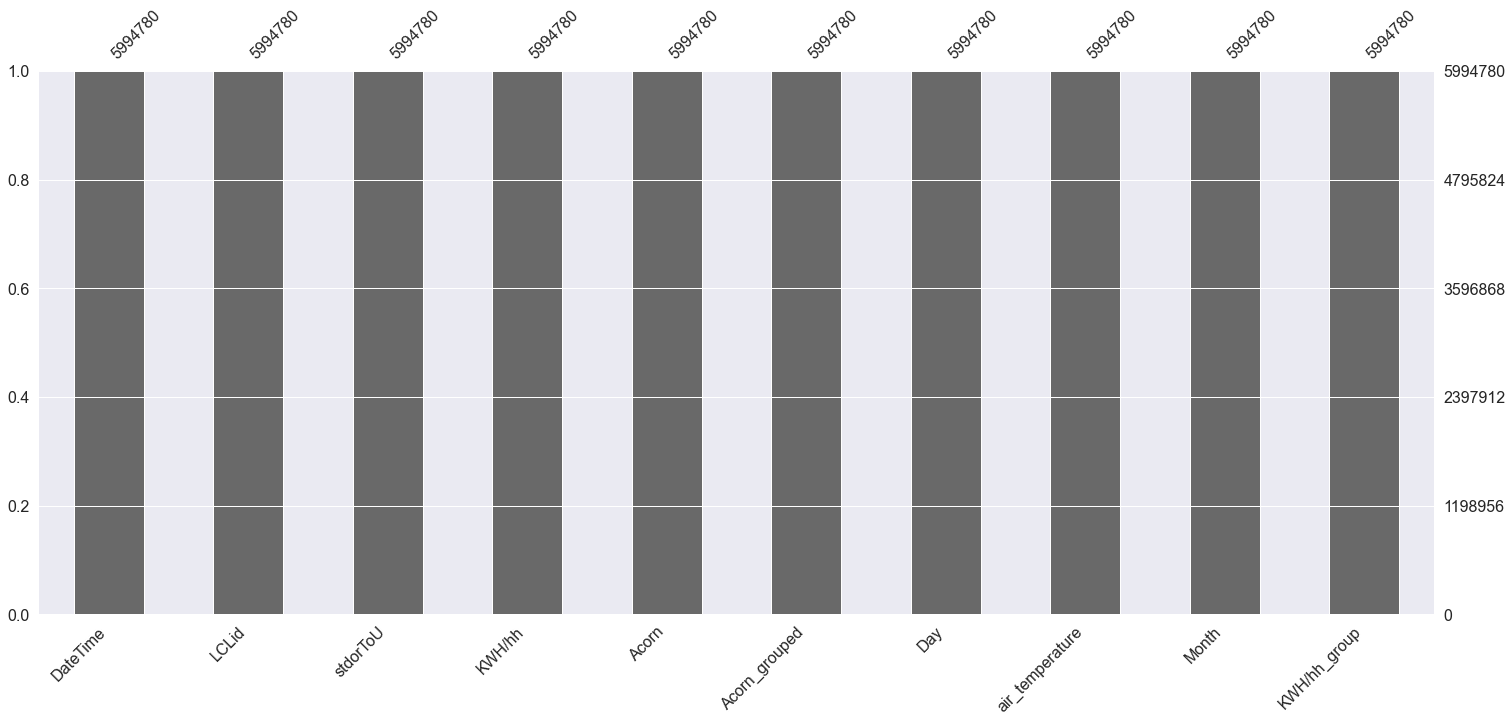

In [88]:
msno.bar(df_less_99th_filtered)

Here we check all our datatypes to make sure they are good. The numbers are floats, the datetime is a the datetime datetype, and the rest are strings which is correct.

In [99]:
df_less_99th_filtered.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5994780 entries, 17580 to 19654439
Data columns (total 10 columns):
 #   Column           Dtype         
---  ------           -----         
 0   DateTime         datetime64[ns]
 1   LCLid            object        
 2   stdorToU         object        
 3   KWH/hh           float64       
 4   Acorn            object        
 5   Acorn_grouped    object        
 6   Day              object        
 7   air_temperature  float64       
 8   Month            object        
 9   KWH/hh_group     category      
dtypes: category(1), datetime64[ns](1), float64(2), object(6)
memory usage: 463.1+ MB


In [89]:
gb1 = df_less_99th_filtered.groupby(['Acorn_grouped', 'stdorToU']) # group by to do more EDA.
groups = dict(list(gb1)) # makes a dict of dataframs which can be accesed below. 

Checking to see how man series belong to each group.

In [90]:
(gb1.size()/17580).round(0) # how many series belong to each group.

Acorn_grouped  stdorToU
Adversity      Std         112.0
               ToU          33.0
Affluent       Std          83.0
               ToU          29.0
Comfortable    Std          58.0
               ToU          26.0
dtype: float64

Here you can see the 5 number summary of the two numerical values KWH/hh and air temperature.

-  The mean KWH/hh for each group are between .11 and .12 for the std classes and between .10 and .11 for tou. Interestingly the mean for the adversity class is higher which is unexpected.

In [91]:
gb1.describe().round(3) # 5 number summary.

KWH/hh                                          \
                            count   mean    std  min    25%    50%    75%   
Acorn_grouped stdorToU                                                      
Adversity     Std       1968960.0  0.121  0.123  0.0  0.044  0.085  0.156   
              ToU        580140.0  0.111  0.128  0.0  0.038  0.072  0.136   
Affluent      Std       1459140.0  0.103  0.113  0.0  0.035  0.069  0.133   
              ToU        509820.0  0.106  0.118  0.0  0.037  0.064  0.131   
Comfortable   Std       1019640.0  0.113  0.115  0.0  0.041  0.079  0.146   
              ToU        457080.0  0.107  0.114  0.0  0.039  0.073  0.134   

                              air_temperature                                \
                          max           count    mean     std    min    25%   
Acorn_grouped stdorToU                                                        
Adversity     Std       1.559       1968960.0  51.681  12.046  24.44  42.44   
              ToU       1.540        580140.0  51.681  12.046  24.44  42.44   
Affluent      Std       1.552       1459140.0  51.681  12.046  24.44  42.44   
              ToU       1.540        509820.0  51.681  12.046  24.44  42.44   
Comfortable   Std       1.557       1019640.0  51.681  12.046  24.44  42.44   
              ToU       1.539        457080.0  51.681  12.046  24.44  42.44   

                                              
                           50%    75%    max  
Acorn_grouped stdorToU                        
Adversity     Std       50.945  60.44  92.66  
              ToU       50.945  60.44  92.66  
Affluent      Std       50.945  60.44  92.66  
              ToU       50.945  60.44  92.66  
Comfortable   Std       50.945  60.44  92.66  
              ToU       50.945  60.44  92.66

In [92]:
Adversity_Std = groups['Adversity', 'Std']
Adversity_ToU = groups['Adversity', 'ToU']
Affluent_Std = groups['Affluent', 'Std']
Affluent_ToU = groups['Affluent', 'ToU']
Comfortable_Std = groups['Comfortable', 'Std']
Comfortable_ToU = groups['Comfortable', 'ToU']

Plot of the number of series for each group.

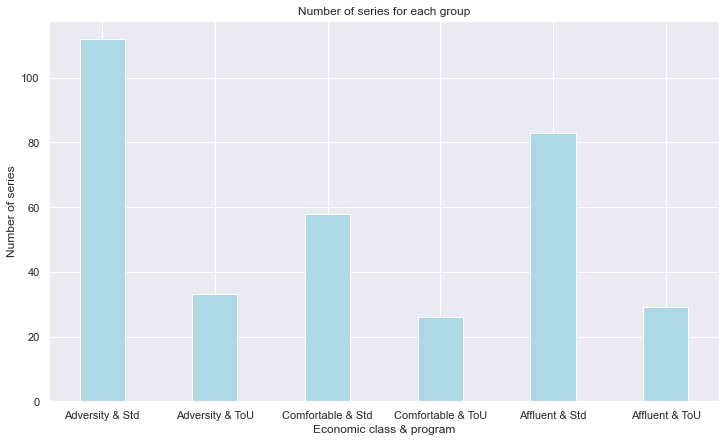

In [93]:
# creating the dataset
group = ['Adversity & Std', 'Adversity & ToU', 'Comfortable & Std', 'Comfortable & ToU',
         'Affluent & Std', 'Affluent & ToU',]
mean = [112, 33, 58, 26, 83, 29] # check these numbers.
   
fig = plt.figure(figsize = (12, 7))
 
# creating the bar plot
plt.bar(group, mean, color ='lightblue',
        width = 0.4)
 
plt.xlabel("Economic class & program")
plt.ylabel("Number of series")
plt.title("Number of series for each group")
plt.show()

Plot of the mean KWH/hh for each group.

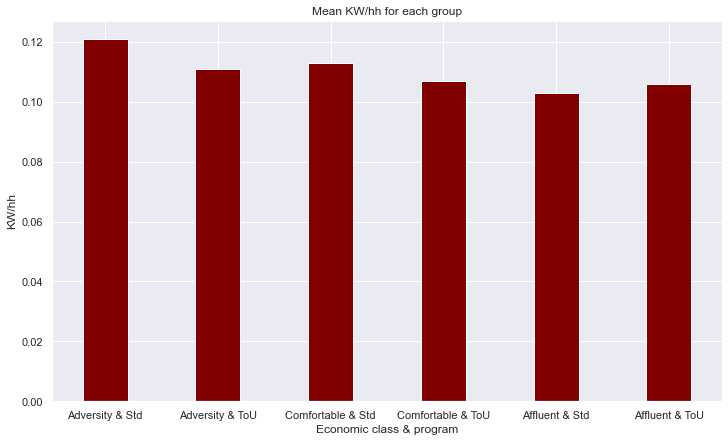

In [94]:
# creating the dataset
group = ['Adversity & Std', 'Adversity & ToU', 'Comfortable & Std', 'Comfortable & ToU',
         'Affluent & Std', 'Affluent & ToU',]
mean = [0.121, 0.111, 0.113, 0.107, 0.103, 0.106] # check these numbers.
   
fig = plt.figure(figsize = (12, 7))
 
# creating the bar plot
plt.bar(group, mean, color ='maroon',
        width = 0.4)
 
plt.xlabel("Economic class & program")
plt.ylabel("KW/hh")
plt.title("Mean KW/hh for each group")
plt.show()

Below we do a groupby to be able to get the date to plot mean KWH/hh by month and acorn group.

In [101]:
gb3 = df_less_99th_filtered.groupby(['Acorn_grouped', 'Month']).mean() # group by to do more EDA.
df3 = pd.DataFrame(gb3) # Put gb in df.

In [103]:
df3

KWH/hh  air_temperature
Acorn_grouped Month                               
Adversity     April      0.119172        47.556697
              August     0.104867        65.831659
              December   0.129467        44.900101
              February   0.132816        38.783859
              January    0.132532        40.243401
              July       0.107214        69.265198
              June       0.106000        59.791763
              March      0.131516        38.838489
              May        0.109825        53.245500
              November   0.125977        45.544719
              October    0.117602        56.331007
              September  0.110318        59.129223
Affluent      April      0.102047        47.556697
              August     0.091270        65.831659
              December   0.112060        44.900101
              February   0.117571        38.783859
              January    0.121560        40.243395
              July       0.093008        69.265198
              June       0.091832        59.791763
              March      0.114354        38.838489
              May        0.093458        53.245500
              November   0.110032        45.544719
              October    0.101673        56.331007
              September  0.098489        59.129223
Comfortable   April      0.108487        47.556697
              August     0.101772        65.831659
              December   0.120110        44.900101
              February   0.122024        38.783859
              January    0.125850        40.243403
              July       0.103455        69.265198
              June       0.101245        59.791763
              March      0.119250        38.838489
              May        0.103261        53.245500
              November   0.117001        45.544719
              October    0.110107        56.331007
              September  0.102113        59.129223

In [102]:
Adversity_kh_per_month = [0.110318, 0.132816, 0.131516, 0.119172, 0.109825, 0.106000, 0.107214,
                          0.104867, 0.110318, 0.117602, 0.125977, 0.129467]

Comfortable_kh_per_month = [0.125850, 0.122024, 0.119250, 0.108487, 0.103261, 0.101245, 0.103455, 
                            0.10177, 0.102113, 0.110107, 0.117001, 0.120110]

Affluent_kh_per_month = [0.121560, 0.117571, 0.114354, 0.102047, 0.0934458, 0.091832, 0.093008, 
                         0.0912270, 0.098489, 0.101673, 0.110032, 0.112060]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',
         'October', 'November', 'December']
temp = [40.243402/100.0, 38.783859/100.0, 38.838489/100.0, 47.556697/100.0, 53.245500/100.0, 59.791763/100.0, 69.265198/100.0, 
        65.831659/100.0, 59.129223/100.0, 56.331007/100.0, 45.544719/100.0, 44.900098/100.0]

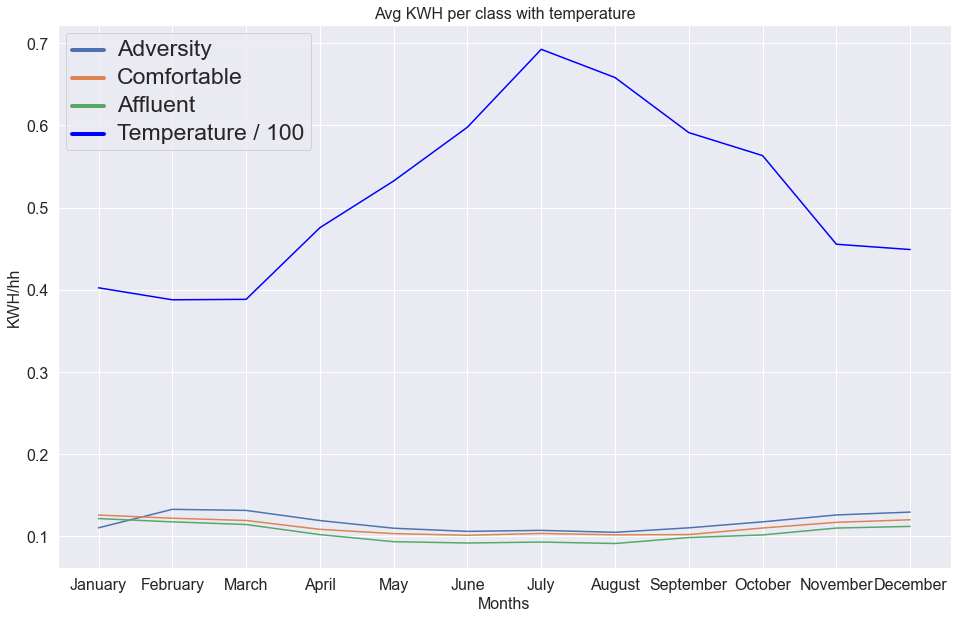

In [105]:
plt.figure(figsize=(16, 10))
# plot lines

plt.plot(months, Adversity_kh_per_month, label = "Adversity")
plt.plot(months, Comfortable_kh_per_month, label = "Comfortable")
plt.plot(months, Affluent_kh_per_month, label = "Affluent")
plt.plot(months, temp, label = "Temperature / 100", color="Blue")

# Add title and axis names
plt.title('Avg KWH per class with temperature')
plt.ylabel('KWH/hh')
plt.xlabel('Months')

leg = plt.legend()
# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=4)
plt.setp(leg_texts, fontsize='x-large')

plt.show()

Below we do a groupby to be able to get the date to plot mean KWH/hh by day and acorn group.

In [107]:
gb5 = df_less_99th_filtered.groupby(['Acorn_grouped', 'Day']).mean() # group by to do more EDA.
df5 = pd.DataFrame(gb5) # Put gb in df.

In [109]:
df5

KWH/hh  air_temperature
Acorn_grouped Day                                 
Adversity     Friday     0.117674        52.104602
              Monday     0.118000        51.996249
              Saturday   0.120011        51.191293
              Sunday     0.124243        51.422454
              Thursday   0.116792        51.934856
              Tuesday    0.117313        51.483037
              Wednesday  0.118341        51.637674
Affluent      Friday     0.102840        52.104602
              Monday     0.102783        51.996249
              Saturday   0.106073        51.191293
              Sunday     0.109554        51.422454
              Thursday   0.101216        51.934856
              Tuesday    0.102667        51.483037
              Wednesday  0.102354        51.637670
Comfortable   Friday     0.109574        52.104602
              Monday     0.111360        51.996249
              Saturday   0.113301        51.191293
              Sunday     0.116100        51.422454
              Thursday   0.109147        51.934856
              Tuesday    0.109942        51.483037
              Wednesday  0.109165        51.637675

In [110]:
Adversity_kh_per_day = [0.118000, 0.117313, 0.118341, 0.116792, 0.117674, 0.120011, 0.124243]

Comfortable_kh_per_day = [0.1113, 0.109942, 0.109165, 0.109147, 0.109574, 0.113301, 0.116100]

Affluent_kh_per_day = [0.102783, 0.102667, 0.102354, 0.101216, 0.102840, 0.106073, 0.109554]

day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

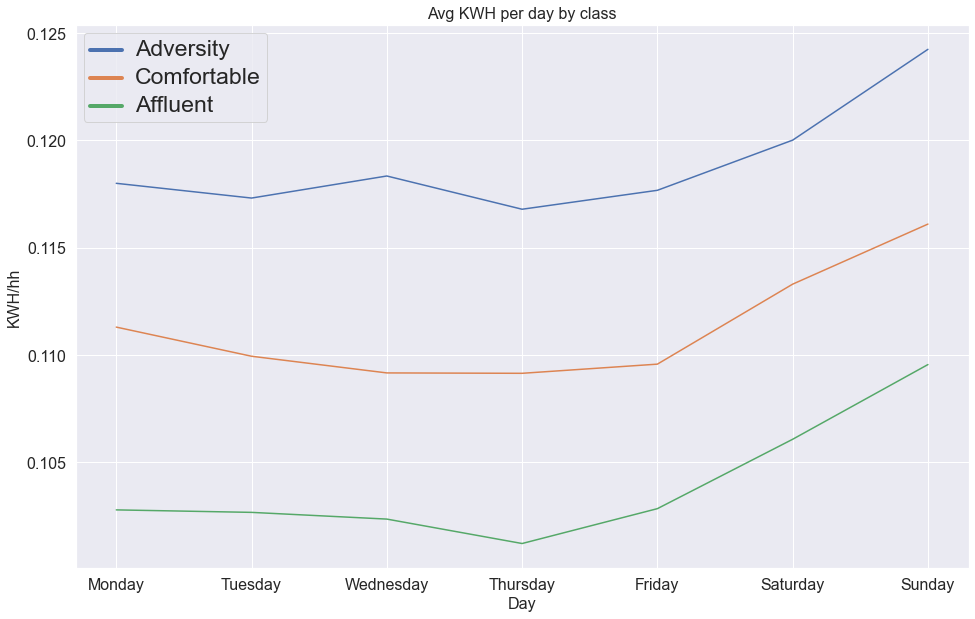

In [114]:
plt.figure(figsize=(16, 10))
# plot lines

plt.plot(day, Adversity_kh_per_day, label = "Adversity")
plt.plot(day, Comfortable_kh_per_day, label = "Comfortable")
plt.plot(day, Affluent_kh_per_day, label = "Affluent")

# Add title and axis names
plt.title('Avg KWH per day by class')
plt.ylabel('KWH/hh')
plt.xlabel('Day')

leg = plt.legend()
# get the lines and texts inside legend box
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=4)
plt.setp(leg_texts, fontsize='x-large')

plt.show()

Here we compute a correlation matrix to see if air temp and KWH/hh have any relationship. As you can see below there very small negative correlation.

<AxesSubplot:>

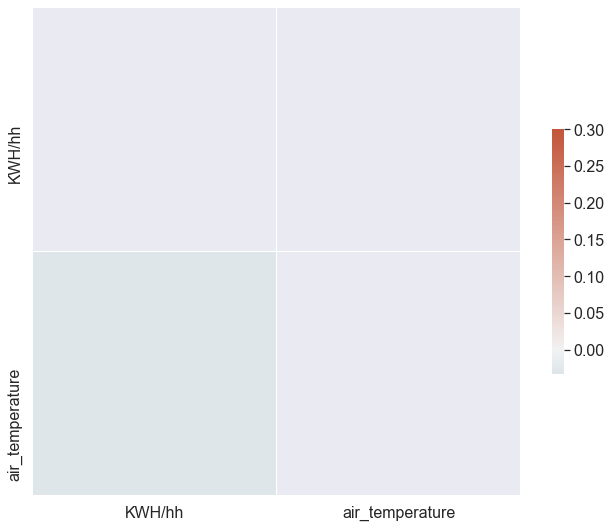

In [113]:
# Compute the correlation matrix
corr = df_less_99th_filtered.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Here we make a box-plot to check the outliers.

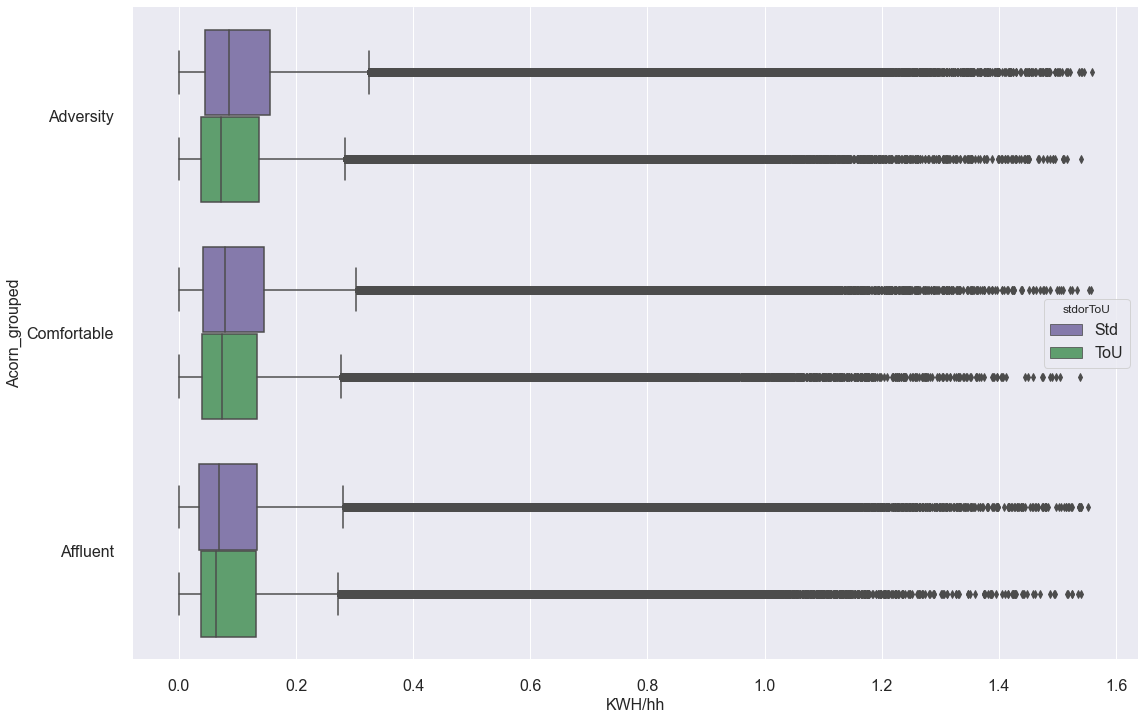

In [115]:
sns.boxplot(x='KWH/hh', y='Acorn_grouped',
            hue="stdorToU", palette=["m", "g", "b"],
            data=df_less_99th_filtered) 
sns.despine(offset=10, trim=True)

# 3. Classification

In this section we are going to explore attempting to classify households based solely on their energy cosumption.

In [ ]:
import plotly.express as px

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

We are going to start with df6 from above. This was filtered all the way down to all the usable lines before we added the tempature data. Since we are only trying to base this on consumption we do not need that portion of the data.

In [ ]:
df6.head()

In [ ]:
df6["groups"] = np.where(df6["Acorn_grouped"] == "Affluent", 1, np.where(df6["Acorn_grouped"] == "Comfortable", 2, 3))

Here we groupby the households to get an idea of what the typical usage is for each home. 

In [ ]:
gb10 = data_frame.groupby("LCLid").agg({"KWH/hh": ["mean", "max"], "groups": "first"})

In [ ]:
gb10.head()

In [ ]:
gb10 = gb10.droplevel(0, axis=1)

First thing to do here is to split into test and training sets. 

In [ ]:
Xtrain, Xtest, y_train, y_test = train_test_split(gb10[["mean", "max"]], gb10["first"], random_state = 5, train_size = 0.8)

From here the first step was to create some basic models to compare our adaptations to. For this we created models using kNN, Decision Trees, Random Forest and SVM.

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(Xtrain, y_train)
knn_pred = knn_model.predict(Xtest)
# accuracy_score(y_test, knn_pred)

In [ ]:
dt_model = tree.DecisionTreeClassifier(min_samples_split=5, random_state=7)
dt_model.fit(Xtrain, y_train)
dt_preds = dt_model.predict(Xtest)
# accuracy_score(y_test, dt_preds)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=5,max_depth=10, random_state=0)
rf_model.fit(Xtrain, y_train)
rf_preds = dt_model.predict(Xtest)
# accuracy_score(y_test, rf_preds)

In [ ]:
svm_model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svm_model.fit(Xtrain, y_train)
svm_preds = svm_model.predict(Xtest)
# accuracy_score(y_test, svm_preds)

In [ ]:
print_model_acc(y_test, knn_preds, dt_preds, rf_preds, svm_preds)

We are going to visualize the predictions to see if there are obvious differences in the models predictions. 

In [3]:
Xtest_answers = Xtest

NameError: name 'Xtest' is not defined

In [ ]:
Xtest_answers["knn"] = knn_pred
Xtest_answers["dt"] = dt_preds
Xtest_answers["rf"] = rf_preds
Xtest_answers["svm"] = svm_preds

In [ ]:
Xtest_answers["knn_correct"] = Xtest_answers.knn == Xtest_answers.target
Xtest_answers["dt_correct"] = Xtest_answers.dt == Xtest_answers.target
Xtest_answers["rf_correct"] = Xtest_answers.rf == Xtest_answers.target
Xtest_answers["svm_correct"] = Xtest_answers.svm == Xtest_answers.target

In [ ]:
px.scatter(Xtest_answers, x="max", y="mean", color="knn_correct", opacity=0.6, symbol='target', category_orders={"knn_correct": [True, False]})

In [ ]:
px.scatter(Xtest_answers, x="max", y="mean", color="svm_correct", opacity=0.6, symbol='target', category_orders={"svm_correct": [True, False]})

In [ ]:
px.scatter(Xtest_answers, x="max", y="mean", color="dt_correct", opacity=0.6, symbol='target',category_orders={"dt_correct": [True, False]})

In [ ]:
px.scatter(Xtest_answers, x="max", y="mean", color="rf_correct", opacity=0.6, symbol='target',category_orders={"rf_correct": [True, False]})

The next step here is to try to optimize each of the models. We are going this with gridsearch cross validation for each of the models. 

In [ ]:
svc_parameters = {'kernel':['linear', 'sigmoid', 'rbf'], 'C':[1, 2, 5, 10, 20], "degree": [3, 5, 10], 'shrinking': [True, False], }
svc = SVC()
svc_grid = GridSearchCV(svc, svc_parameters)
svc_grid.fit(Xtrain, y_train)

In [ ]:
svc_grid.best_params_

In [ ]:
svc_grid.best_score_

In [ ]:
knn_parameters = {
    "n_neighbors": [2, 3, 4, 5, 7, 10, 20],
    "algorithm": ["auto", "ball_tree", "kd_tree"],
    "p": [1, 2, 3],
    "leaf_size": [10, 30, 50, 100],
    "weights": ["uniform", "distance"],
}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_parameters)
knn_grid.fit(Xtrain, y_train)

In [ ]:
knn_grid.best_params_

In [ ]:
knn_grid.best_score_

In [ ]:
dt_parameters = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [5, 10, 15, 20, 30],
    "min_samples_leaf": [1, 2, 5, 10],
}
dt = tree.DecisionTreeClassifier()
dt_grid = GridSearchCV(dt, dt_parameters)
dt_grid.fit(Xtrain, y_train)

In [ ]:
dt_grid.best_params_

In [ ]:
dt_grid.best_score_

In [ ]:
rf_parameters = {
    "n_estimators": [5, 10, 50, 100, 200, 500],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [5, 10, 15, 20, 30, None],
    "min_samples_leaf": [1, 2, 5, 10],
    "min_weight_fraction_leaf": [0.0, 0.3, 0.7, 1, 2]
}
rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, rf_parameters)
rf_grid.fit(Xtrain, y_train)

In [ ]:
rf_grid.best_params_

In [ ]:
rf_grid.best_score_

As you can see each of these models except for kNN was optimized via the grid search to improve the accuaracy. Now we are going to run the Xtest data through these models. 

In [ ]:
rf_preds_2 = rf_model.predict(Xtest)
# accuracy_score(y_test, rf_preds_2)

In [ ]:
dt_preds_2 = dt_model.predict(Xtest)
# accuracy_score(y_test, dt_preds_2)

In [ ]:
knn_preds_2 = knn_model.predict(Xtest)
# accuracy_score(y_test, knn_preds_2)

In [ ]:
svm_preds_2 = svm_model.predict(Xtest)
# accuracy_score(y_test, svm_preds_2)

In [ ]:
print_model_acc(y_test, knn_preds_2, dt_preds_2, rf_preds_2, svm_preds_2)

This has shown that even in the test data these models all improved slightly. But we have not dramatically improved over the SVM base model yet. We are going to look at the visual outputs of the predictions again.

In [ ]:
Xtest_answers_2 = Xtest

In [ ]:
Xtest_answers_2["knn"] = knn_pred_2
Xtest_answers_2["dt"] = dt_preds_2
Xtest_answers_2["rf"] = rf_preds_2
Xtest_answers_2["svm"] = svm_preds_2

In [ ]:
Xtest_answers_2["knn_correct"] = Xtest_answers_2.knn == Xtest_answers_2.target
Xtest_answers_2["dt_correct"] = Xtest_answers_2.dt == Xtest_answers_2.target
Xtest_answers_2["rf_correct"] = Xtest_answers_2.rf == Xtest_answers_2.target
Xtest_answers_2["svm_correct"] = Xtest_answers_2.svm == Xtest_answers_2.target

In [ ]:
px.scatter(Xtest_answers_2, x="max", y="mean", color="knn_correct", opacity=0.6, symbol='target', category_orders={"knn_correct": [True, False]})

In [ ]:
px.scatter(Xtest_answers_2, x="max", y="mean", color="svm_correct", opacity=0.6, symbol='target', category_orders={"svm_correct": [True, False]})

In [ ]:
px.scatter(Xtest_answers_2, x="max", y="mean", color="dt_correct", opacity=0.6, symbol='target',category_orders={"dt_correct": [True, False]})

In [ ]:
px.scatter(Xtest_answers_2, x="max", y="mean", color="rf_correct", opacity=0.6, symbol='target',category_orders={"rf_correct": [True, False]})

After inspecting these there are some instances that are easy to see where multiple models where getting the same prediction but a third model was wrong. Therefore it seems obvious that we could attempt to implement a voting system and potentially improve the overall performance of the models if they are used together. 

The first voting system gives every model the same weight. The second gives a larger weigtht to SVM.  

In [ ]:
final_array = voting_system(svm_preds, knn_preds, dt_preds, rf_preds)

In [ ]:
accuracy_score(y_test, final_array)

In [ ]:
final_array2 = voting_system(svm_preds, knn_preds, dt_preds, rf_preds)

In [ ]:
accuracy_score(y_test, final_array2)

As you can see we did not improve the accuracy of the overall system compared to the optimized SVM. Therfore for this dataset that is the best model.

The last thing we are going to explore is removing the top 1% as we did above and see if that helps the classification models. 

1. Data Cleaning (use read_data from utils.py)
2. Data Exploration
    1. Creating features
    1. Adding Temp?
    1. Clustering
3. Time Series Analysis
    1. Building models
    1. Evaluating models
    1. Major Takeaways/Results
4. Classification Analysis
    1. Building models
    1. Evaluating models
    1. Major Takeaways/Results